## Zadanie domowe: morfologiczna gra w życie – John Conway

### Wykorzystanie operacji LUT w przekształceniu trafi, nie trafi
  - Szybszą metodą wykonania transformacji trafi, nie trafi może być operacja LUT.
  - Technika polega na zakodowaniu wyników wszystkich interesujących  konfiguracji, a następnie podczas przetwarzania wykorzystania operacji LUT.
  - Dla otoczenia 3x3 możliwe jest 512 różnych konfiguracji.
  - Aby praktycznie zrealizować operacje, każdej konfiguracji należy nadać unikalny indeks. Jedną z możliwości jest pomnożenie elementu strukturalnego przez macierz (mnożenie odpowiednich elementów):
  ```
  [[1, 8,  64],
   [ 2, 16, 128],
   [ 4, 32, 256]]
  ```
  Przykładowo elementowi:
  ```
  [[1, 1, 0],
   [ 1, 0, 1],
   [ 1, 0, 1]]
  ```
  odpowiada liczba: 1(1) + 2(1) + 4(1) + 8(1) + 128(1) + 256(1) = 399.
  
### Przykład działania metody – detekcja punktów końcowych na obrazie.
  - założenie: punkt końcowy to punkt, który ma dokładnie jednego sąsiada,
  - zdefiniuj funkcję, która jako argument pobiera otoczenie, a zwraca 0 lub 1 w zależności od tego, czy rozpatrywany punkt jest końcowy np. dla sąsiedztwa 3×3 punkt będzie końcowy, jeżeli jest zapalony i ma tylko jednego sąsiada (czyli suma pikseli jest równa 2).
  - wygeneruj przekodowanie LUT.
  - wczytaj obraz szkielet.bmp (należy go przekształcić, aby uzyskać dwuwymiarową tablicę o wartościach 0-1). Wykorzystując wygenerowane przekodowanie LUT wykonaj detekcję zakończeń. Wyświetl obraz oryginalny i po przekodowaniu LUT.

### Gra w życie

Reguły gry w życie:
  - każdy piksel biały, który ma dwóch lub trzech sąsiadów (białych) przeżywa,
  - każdy piksel biały, który ma 0,1 lub więcej niż trzech sąsiadów (białych) nie przeżywa (głód lub przeludnienie),
  - jeżeli jakieś pole (czarne) sąsiaduje dokładnie z trzema pikselami białymi, to na tym polu ,,rodzi'' się nowy piksel biały.

Zadanie:
  - za pomocą mechanizmu LUT (opisanego wcześniej) należy zaimplementować morfologiczną gre w życie,
  - najważniejszym elementem jest funkcja opisująca reguły gry,
  - symulacje należny przeprowadzić dla plansz dostarczonych w pliku gra.py,
  - dobrze jest wykonać kilka iteracji – zobaczyć jak zmienia się kształt,
  - inne ciekawe kształty do znalezienia w internecie.


In [101]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import requests

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/10_Morphology/'

fileNames = ["gra.py"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

In [102]:
# gra.py
import numpy as np

plansza1 = np.array([
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	1,	0,	0,	1,	0,	0,	0],
    [0,	0,	0,	1,	1,	1,	1,	0,	0,	0],
    [0,	0,	1,	0,	0,	0,	0,	1,	0,	0],
    [0,	0,	1,	0,	1,	1,	0,	1,	0,	0],
    [0,	0,	1,	0,	0,	0,	0,	1,	0,	0],
    [0,	0,	0,	1,	1,	1,	1,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0]], np.uint8)

plansza2 = np.array([
    [0,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1],
    [0,	0,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	1,	1],
    [1,	1,	1,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0],
    [0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0,	0]], np.uint8)

## Detekcja punktow koncowych na obrazie

In [103]:
def indeks_lut(neighbourhood: np.array):
  M = np.array([[1, 8, 64], [2, 16, 128], [4, 32, 256]])
  return np.sum(neighbourhood * M)

def punkt_koncowy(neighbourhood: np.array) -> int:
  # middle point is 1 and sum of all points is 2
  return int(neighbourhood[1, 1] == 1 and np.sum(neighbourhood) == 2)


In [104]:
neighbourhood = np.array([[1, 1, 0], [1, 0, 1], [1, 0, 1]])
print(indeks_lut(neighbourhood))
neighbourhood = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1]])
print(punkt_koncowy(neighbourhood))

399
1


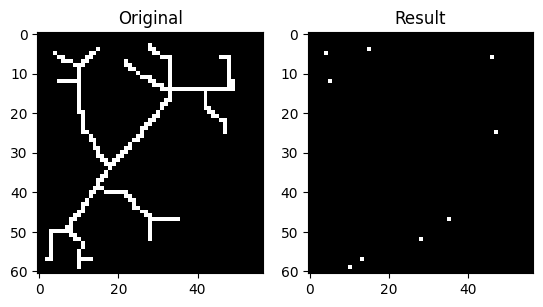

In [105]:
img = cv2.imread('szkielet.bmp', cv2.IMREAD_GRAYSCALE)
img = np.array(img / 255, np.uint8)
result = np.zeros_like(img)


for i in range(1, img.shape[0] - 1):
  for j in range(1, img.shape[1] - 1):
    # Cut 3x3 neighbourhood
    neighbourhood = img[i-1:i+2, j-1:j+2]
    result[i, j] = punkt_koncowy(neighbourhood)

result = np.array(result * 255, np.uint8)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, 'gray')
axs[0].set_title('Original')
axs[1].imshow(result, 'gray')
axs[1].set_title('Result')
plt.show()

## Gra w zycie

In [106]:
def gra_w_zycie(board: np.array) -> np.array:
  new_board = np.zeros_like(board)
  for i in range(1, board.shape[0] - 1):
    for j in range(1, board.shape[1] - 1):
      # Cut 3x3 neighbourhood
      otoczenie = board[i-1:i+2, j-1:j+2]
      
      # Rules
      alive_neighbours = np.sum(otoczenie) - board[i, j]
      if board[i, j] == 1:
        if alive_neighbours == 2 or alive_neighbours == 3:
          new_board[i, j] = 1 
        else:
          new_board[i, j] = 0
      else:
        if alive_neighbours == 3: 
          new_board[i, j] = 1
        else: 
          new_board[i, j] = 0
  return new_board



#### Plansza1

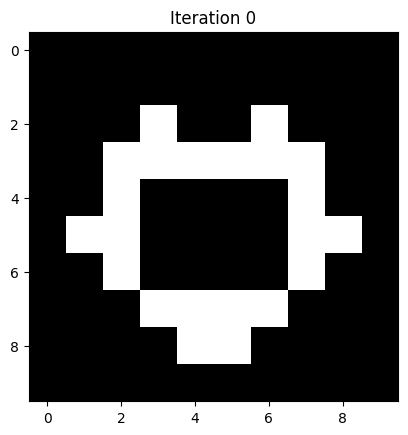

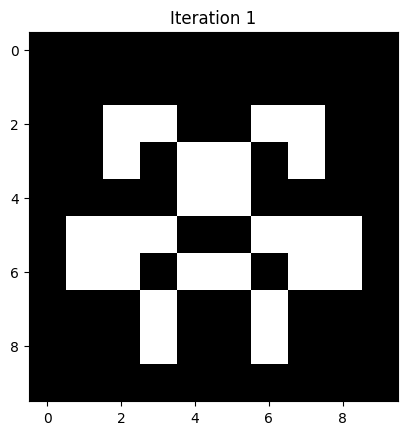

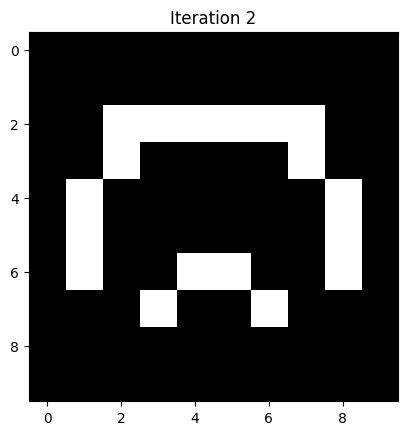

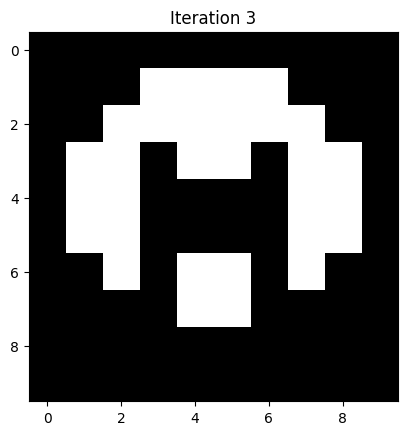

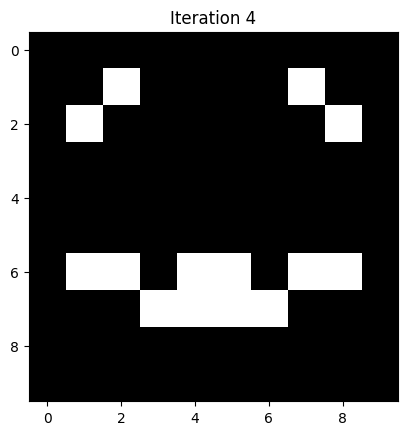

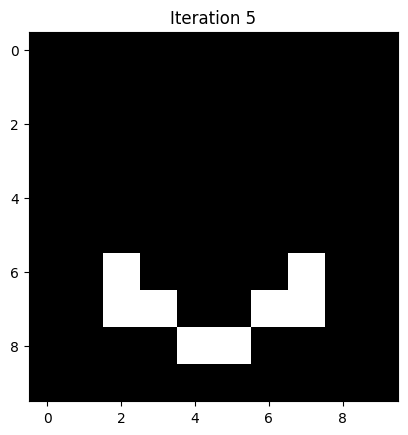

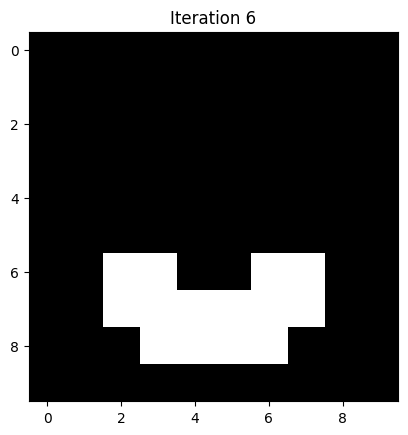

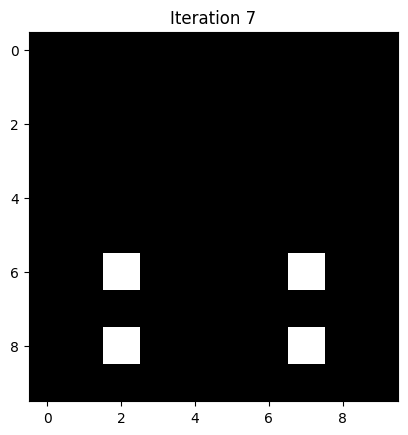

In [107]:

for i in range(8):
  plansza1 = gra_w_zycie(plansza1)
  plt.imshow(plansza1, 'gray')
  plt.title(f'Iteration {i}')
  plt.show()


#### Plansza2

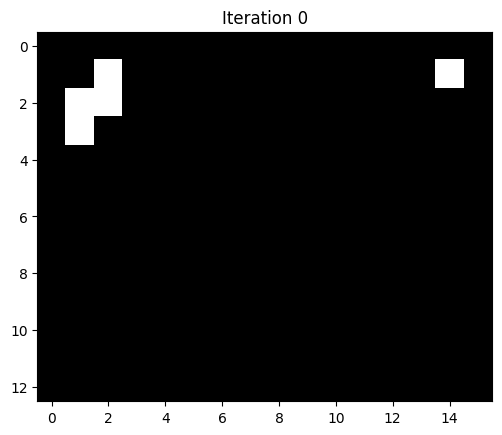

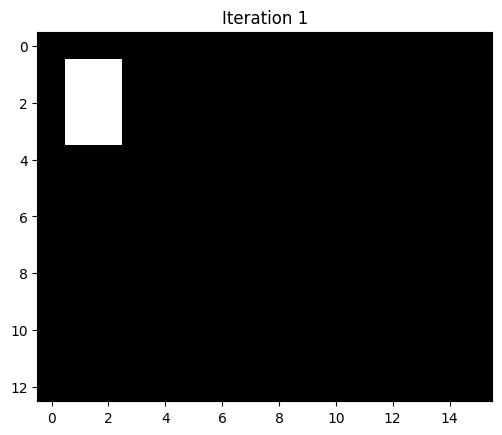

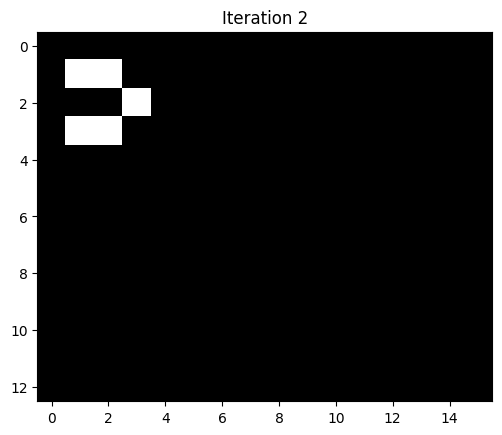

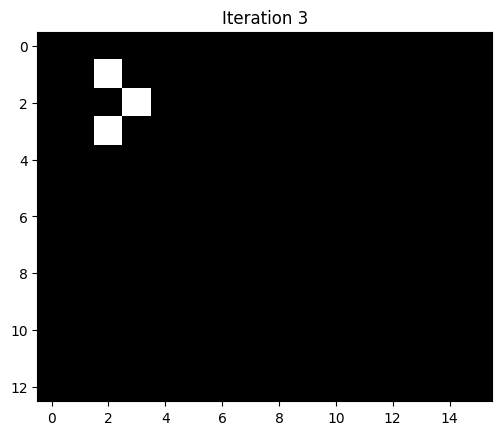

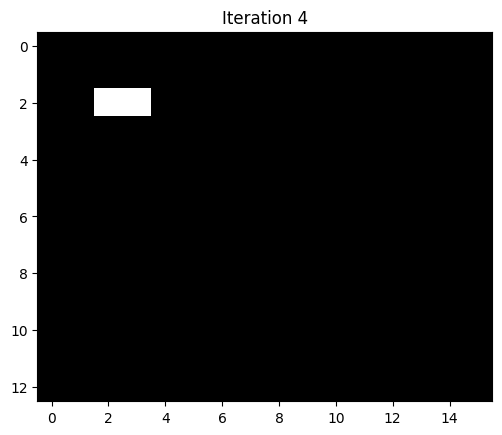

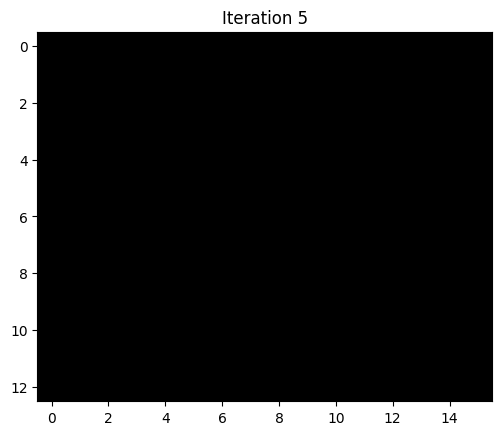

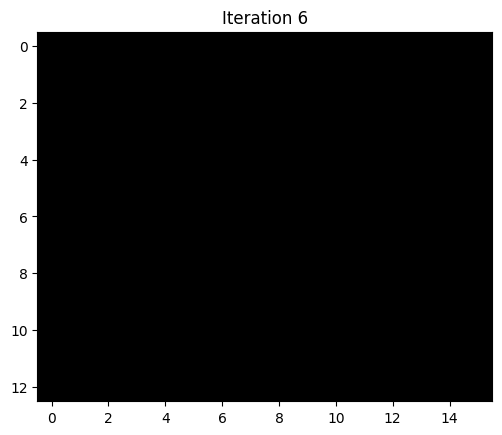

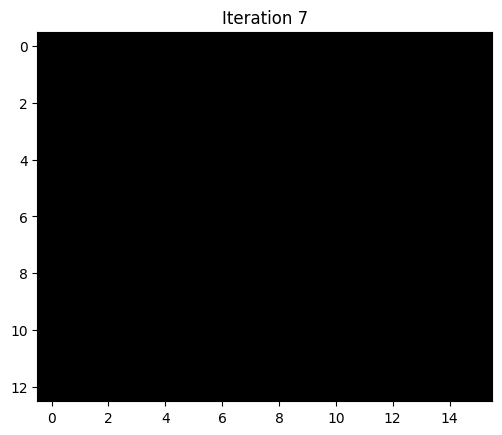

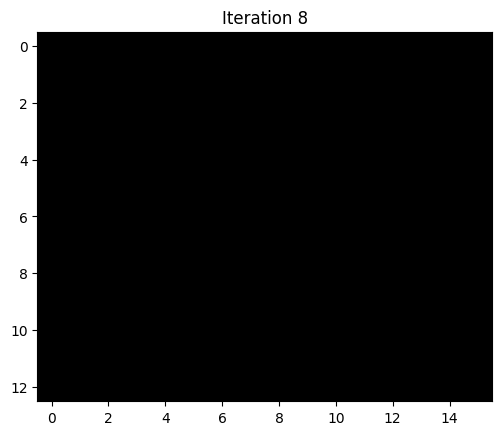

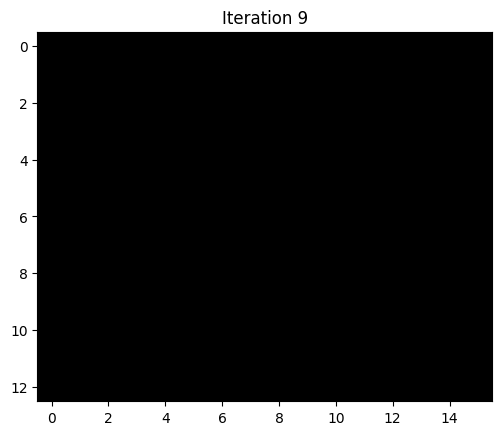

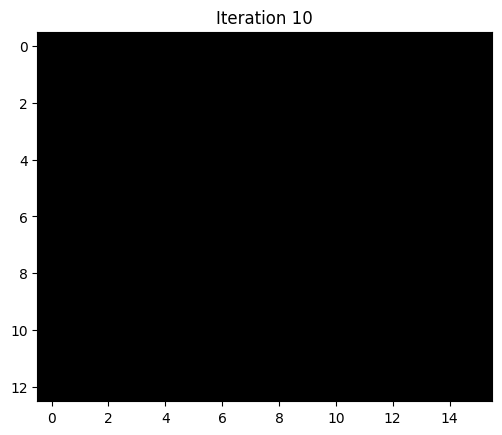

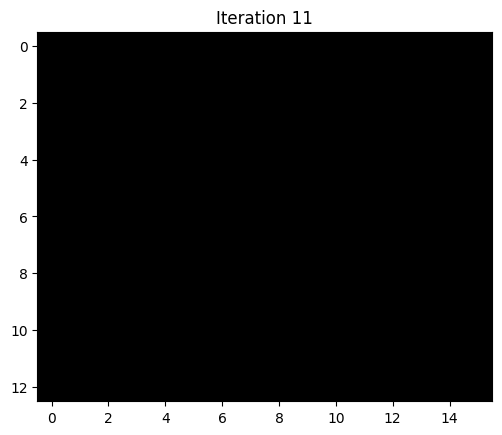

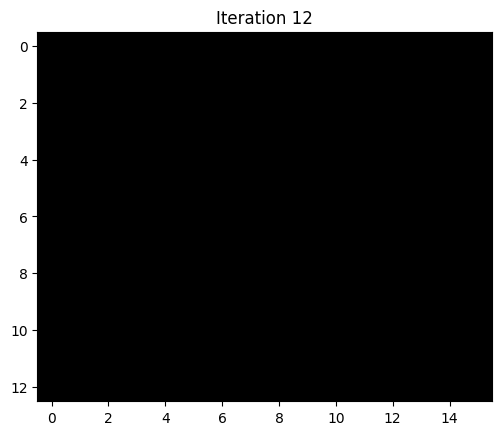

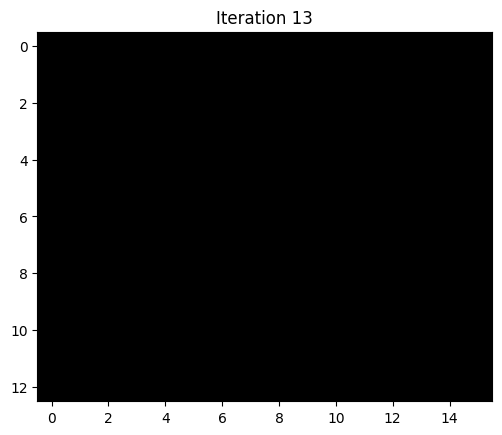

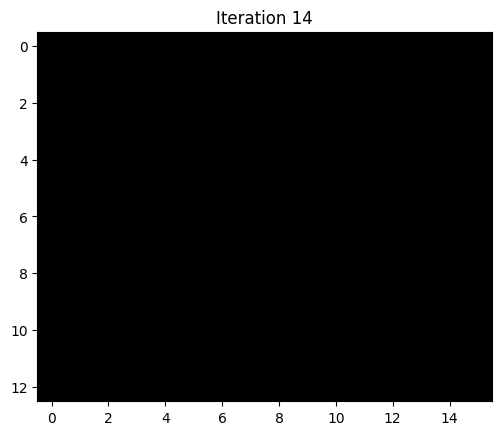

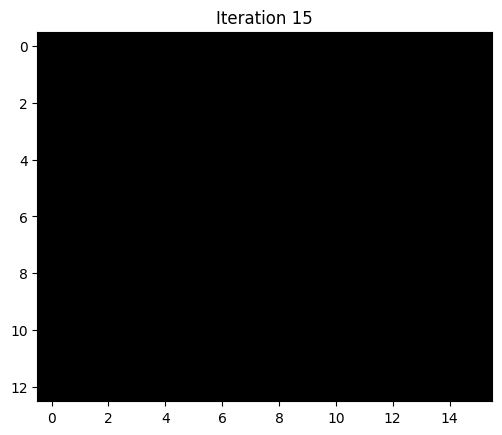

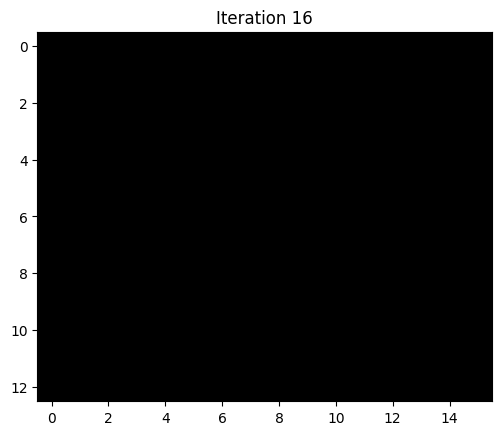

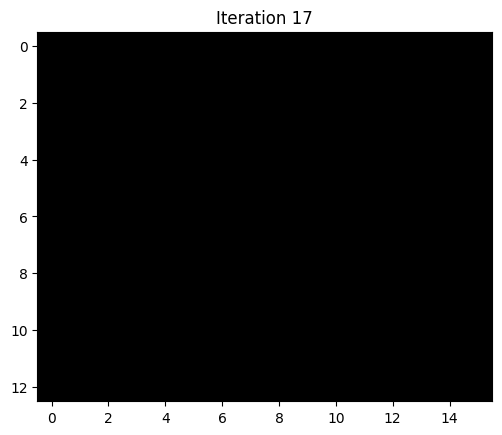

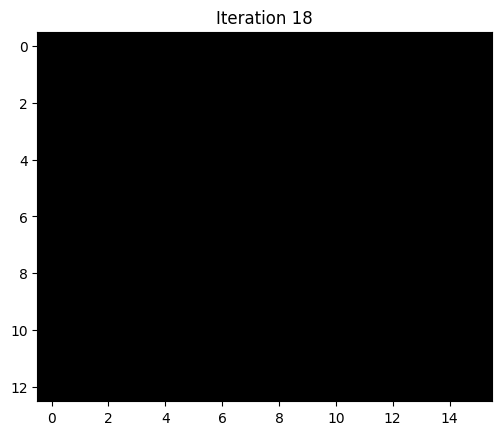

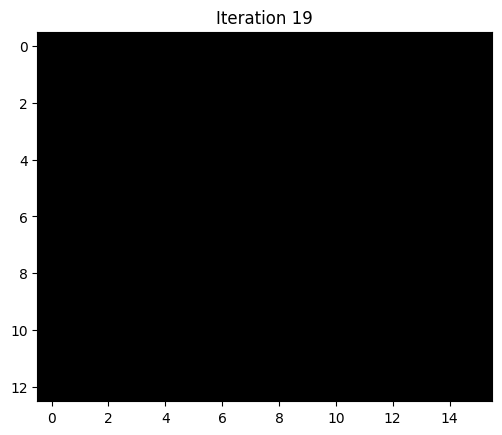

In [108]:
for i in range(20):
    plansza2 = gra_w_zycie(plansza2)
    plt.imshow(plansza2, 'gray')
    plt.title(f'Iteration {i}')
    plt.show()